In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import requests
import zipfile
import io

from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [20,20]

#### Download SBB timetable data in GTFS format

In [13]:
link_to_sbb_dataset = 'https://bit.ly/3AWzUoD'
target_data_path = os.path.join(os.getcwd(),'sbb_data')
r = requests.get(link_to_sbb_dataset)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(target_data_path)

# folder_old = 'gtfs_fp2021_2021-12-01_09-10'
# folder = 'gtfs_fp2022_2022-02-02_17-26'
files = os.listdir(target_data_path)

files_pd = []

for file in files:
    current_file = pd.read_csv(os.path.join(folder,file))
    files_pd.append(current_file)
    #print(current_file.columns)

#### Load `stops` filee

In [14]:
stops = files_pd[6]
stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,1100008,"Zell (Wiesental), Wilder Mann",47.710084,7.859648,NaN,NaN
1,1100009,"Zell (Wiesental), Grönland",47.713191,7.862909,NaN,NaN
2,1100010,Atzenbach,47.714618,7.872350,NaN,NaN
3,1100011,"Mambach, Brücke",47.728209,7.877470,NaN,NaN
4,1100012,"Mambach, Mühlschau",47.734082,7.881387,NaN,NaN


#### Load `trips` file and convert time from hhmmss since midnight to seconds

In [5]:
def gtfs_time_to_minutes(gtfs_time_string):
    hh, mm, ss = map(int, gtfs_time_string.split(':'))
    return hh*60*60 + mm*60 + ss

def gtfs_time_to_hhmmss(gtfs_time_value):
    hh = gtfs_time_value // (60*60)
    mm = (gtfs_time_value - hh*60*60) // 60
    ss = gtfs_time_value - hh*60*60 - mm*60
    return f"{str(hh).zfill(2)}:{str(mm).zfill(2)}:{str(ss).zfill(2)}" 

#print(gtfs_time_to_minutes("15:00:00"))
#print(gtfs_time_to_hhmmss(7266))

trips = files_pd[3]
trips.arrival_time = trips.arrival_time.map(gtfs_time_to_minutes)
trips.departure_time = trips.departure_time.map(gtfs_time_to_minutes)
trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,1.TA.91-m2-j22-1.1.H,65820,65820,8592050,1,0,0
1,1.TA.91-m2-j22-1.1.H,65880,65880,8591818,2,0,0
2,1.TA.91-m2-j22-1.1.H,65940,65940,8590442,3,0,0
3,1.TA.91-m2-j22-1.1.H,66060,66060,8589523,4,0,0
4,1.TA.91-m2-j22-1.1.H,66120,66120,8579237,5,0,0


#### Merge in stop names

In [6]:
trips_full = pd.merge(trips, stops, left_on='stop_id', right_on='stop_id', how='left')

#### Clean & filter down to a city and timeframe

In [7]:
# Remove trips without stop name
trips_full = trips_full[trips_full['stop_name'].map(lambda x: not isinstance(x,float))]

In [8]:
# Filter down to city
city = 'Basel'
trips_full_filtered = trips_full[trips_full['stop_name'].map(lambda x: x.startswith(city))]

In [8]:
# Wherever a stop has a parent (e.g. main station with multiple IDs for different platforms), collapse to single stop_id

def collapse_stop_id(df_row):
    '''if the stop id has a parent, replace it by that parent'''
    
    parent = df_row.parent_station
    
    if isinstance(parent, str):   
        if df_row.parent_station.startswith("Parent"):
            df_row.loc['stop_id'] = df_row.loc['parent_station'][6:]

    return df_row

trips_full_filtered = trips_full_filtered.apply(collapse_stop_id, axis=1, result_type='broadcast')



In [50]:
# Filter down to trips between times

begin_hour = 12 
end_hour   = 15

begin_bound = gtfs_time_to_minutes(f"{str(begin_hour).zfill(2)}:00:00")
end_bound = gtfs_time_to_minutes(f"{str(end_hour).zfill(2)}:00:00")

trips_full_filtered = trips_full_filtered[(trips_full_filtered['arrival_time'] > begin_bound) & 
                                          (trips_full_filtered['arrival_time'] < end_bound)]

#trips_full_filtered.to_excel(f"{city}_trips.xlsx")

#### Convert to distance matrix using the following logic

```
For every trip
    For every stop 
        if sequence = 1
            set from
            set departure_time
        else:
            set to
            get arrival_time
            calc time_delta
            add in correct position in graph
            set from to to
            set departure_time
```

In [51]:
trips_   = trips_full_filtered
trip_ids = trips_.trip_id.unique()
stop_ids = pd.Series(trips_.stop_id.unique())
nstops   = stop_ids.shape[0]
graph    = np.zeros((nstops, nstops))

In [52]:
def get_stop_index_in_graph(stop_id):
    return stop_ids.index[stop_ids == stop_id].tolist()

def get_stop_name(stop_id):
    return stops.stop_name[stops.stop_id == stop_id].tolist()

This does not take into account transfer times and wait times...

In [53]:
for trip_id in trip_ids:

    df = trips_[trips_.trip_id == trip_id].sort_values(by='stop_sequence', ascending=True)
    idx = 0
    
    for _, row in df.iterrows():
        
        if idx == 0:
            stop_from = row.stop_id
            dep_time  = row.departure_time
            idx += 1
            
        else:
            stop_to  = row.stop_id
            arr_time = row.arrival_time
            duration = arr_time - dep_time
            
            #print(f"FROM {get_stop_name(stop_from)} -- TO {get_stop_name(stop_to)}")
            
            idx_from = get_stop_index_in_graph(stop_from)
            idx_to = get_stop_index_in_graph(stop_to)
            graph[idx_from, idx_to] = duration
                    
            stop_from = row.stop_id
            dep_time = row.departure_time
            idx += 1           

#### Plot sparse graph of travel distances between stops

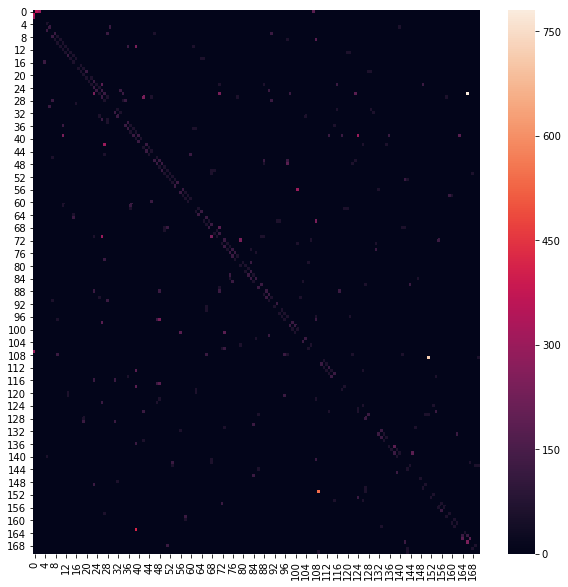

In [66]:
sns.heatmap(graph)

#### Complete graph using Dijkstra and remove any outlier stops

In [55]:
graph_completed = graph_shortest_path(graph)

keep = graph_completed.mean(axis=0) > 200   # this parameter needs to be set manually based on the plot below
graph_completed_clean = graph_completed[keep, :]
graph_completed_clean = graph_completed_clean[:, keep]
stop_ids_clean = stop_ids[keep]

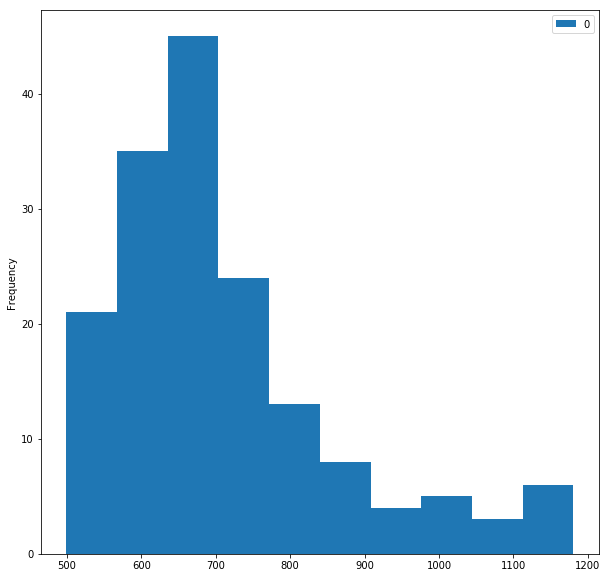

In [65]:
pd.DataFrame(graph_completed_clean.mean(axis=0)).plot.hist()

#### Create dataframe of unique stops within a city

In [57]:
stops_ = pd.merge(pd.DataFrame({"stop_id":stop_ids_clean}), stops, left_on="stop_id", right_on="stop_id").drop(['location_type', 'parent_station'], axis=1)
print(stops_.shape)
stops_.tail()


(164, 4)


,stop_id,stop_name,stop_lat,stop_lon
159,8594925,"Basel EuroAirport, Cargo",47.591984,7.544088
160,8578146,"Basel, Friedrich-Miescher-Str.",47.573879,7.564839
161,8589297,"Basel, Blotzheimerstrasse",47.561405,7.568585
162,8589308,"Basel, Ensisheimerstrasse",47.563145,7.566078
163,8589294,"Basel, Belforterstrasse",47.565303,7.558973


#### Plot augmented distance matrix

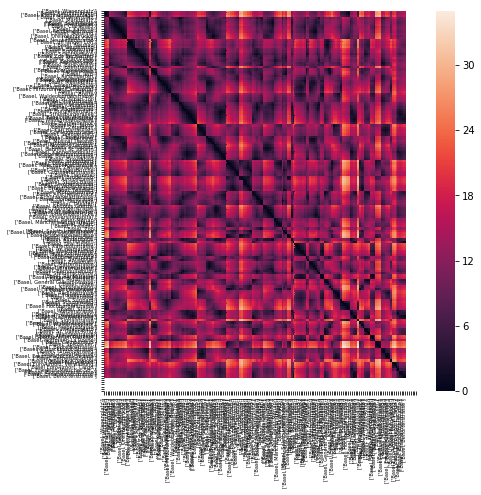

In [64]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

fig, ax = plt.subplots(1,1)
sns.heatmap(graph_completed_clean/60, ax=ax)

_ = ax.set_xticks(range(graph_completed.shape[0]))
_ = ax.set_xticklabels(stop_ids_clean.map(get_stop_name), size=5)
_ = ax.set_yticks(range(graph_completed.shape[0]))
_ = ax.set_yticklabels(stop_ids_clean.map(get_stop_name), size=5)

plt.savefig(f"{city}_distmatrix", dpi=300)

In [59]:
#sns.distplot((graph_completed/60).flatten())

In [60]:
stops_.head()

,stop_id,stop_name,stop_lat,stop_lon
0,8500254,"Basel, Wiesenplatz",47.576697,7.591384
1,8589334,"Basel, Kleinhüningen",47.581054,7.592453
2,8589374,"Basel, Kleinhüningeranlage",47.583708,7.593818
3,8500897,"Basel, Barfüsserplatz",47.554591,7.589057
4,8588775,"Basel, Marktplatz",47.558107,7.587602


In [142]:
stops_named = stop_ids.map(get_stop_name)

def query_finder(x, query):
    if len(x) == 0: 
        return False
    return x[0].find(query) > 0


def get_stop_index(query):
    res = stops_[stops_.stop_name.map(lambda x: x.find(query) > 0)]
    if res.shape[0] == 0:
        return None
    else:
        return res.index[0], res.stop_name.values[0]

#print(get_stop_index("Riehenring"))
#print(get_stop_index("Kinderspital"))

def get_distance(from_, to_, graph=graph_completed):
    from_idx = get_stop_index(from_)
    to_idx = get_stop_index(to_)
    
    if from_idx is None:
        print(f"No stop found for {from_}")
        return
    if to_idx is None:
        print(f"No stop found for {to_}")
        return
    
    dist = graph[from_idx[0], to_idx[0]]/60
    if dist == 0:
        print("distance zero - trip not found or identical stops")
    
    print(f"From {from_idx[1]} to {to_idx[1]}: {dist} minutes")
    #return dist

get_distance("Clarastrasse", "Claraplatz")
get_distance("Clarastrasse", "Claraplatz", graph=graph)

From Basel, Clarastrasse to Basel, Claraplatz: 10.0 minutes
distance zero - trip not found or identical stops
From Basel, Clarastrasse to Basel, Claraplatz: 0.0 minutes


In [63]:
get_stop_index("Claraplatz")

(7, 'Basel, Claraplatz')

#### Debugging
* some trips beetween adjacent stops are too long (Claraplatz / Clarastrasse 10 min.)

In [107]:
# Find all trips between clarastr and clarapl and see where the 10 mins come from
trips.head()

def get_stop_id(stop_name1):
    return stops_[stops_.stop_name.map(lambda x: x.find(stop_name1) > 0)].stop_id.values[0]




In [127]:
clara_id = get_stop_id("Claraplatz")
clarast_id = get_stop_id("Clarastrasse")

print(clarapl_id)
print(clarast_id)

clarapl_trips_id = set(trips_[trips_.stop_id == clarapl_id].trip_id.values)
clarast_trips_id = set(trips_[trips_.stop_id == clarast_id].trip_id.values)

clara_pl_st_ids = list(clarapl_trips_id.intersection(clarast_trips_id))

for clara_id in clara_pl_st_ids:
    dep = trips_[trips_.trip_id == clara_id].sort_values(by='stop_sequence').iloc[1,:]
    dep_name = dep.stop_name
    dep_time = dep.departure_time
    
    arr = trips_[trips_.trip_id == clara_id].sort_values(by='stop_sequence').iloc[2,:]
    arr_name = arr.stop_name
    arr_time = arr.arrival_time
    
    if dep_name != "Basel, Clarastrasse":
        print(dep_name)
    
    print((arr_time-dep_time)/60)

8500898
8589305
2.0
Basel, Allschwilerplatz
2.0
1.0
Basel, Brombacherstrasse
2.0
Basel, Allschwilerplatz
1.0
Basel, Hirzbrunnen/Claraspital
1.0
Basel, Allschwilerplatz
2.0
Basel, Hirzbrunnen/Claraspital
2.0
Basel, Hirzbrunnen/Claraspital
1.0
Basel, Hirzbrunnen/Claraspital
2.0
Basel, Allschwilerplatz
1.0
Basel, Bankverein
2.0
Basel, Hirzbrunnen/Claraspital
2.0
Basel, Brombacherstrasse
2.0
Basel, Hirzbrunnen/Claraspital
1.0
Basel, Allschwilerplatz
1.0
Basel, Allschwilerplatz
2.0
1.0
Basel, Hirzbrunnen/Claraspital
2.0
Basel, Hirzbrunnen/Claraspital
1.0
1.0
Basel, Zeughaus
1.0
1.0
Basel, Allschwilerplatz
2.0
Basel, Allschwilerplatz
2.0
Basel, Zeughaus
1.0
Basel, Brombacherstrasse
2.0
2.0
1.0
Basel, Hirzbrunnen/Claraspital
2.0
Basel, Zeughaus
1.0
Basel, Allschwilerplatz
2.0
Basel, Marktplatz
2.0
Basel, Brombacherstrasse
2.0
Basel, Hirzbrunnen/Claraspital
1.0
Basel, Brombacherstrasse
1.0
Basel, Zeughaus
1.0
1.0
1.0
2.0
Basel, Allschwilerplatz
1.0
Basel, Zeughaus
1.0
Basel, Brombacherstrasse


In [109]:
clarapl_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_name,stop_lat,stop_lon,location_type,parent_station
1631535,36.TA.91-8-B-j21-1.4.H,43620,43620,8500898,17,0,0,"Basel, Claraplatz",47.5618,7.59358,NaN,NaN
1631943,53.TA.91-8-B-j21-1.4.H,44520,44520,8500898,17,0,0,"Basel, Claraplatz",47.5618,7.59358,NaN,NaN
1632183,63.TA.91-8-B-j21-1.4.H,46320,46320,8500898,17,0,0,"Basel, Claraplatz",47.5618,7.59358,NaN,NaN
1632327,69.TA.91-8-B-j21-1.4.H,43620,43620,8500898,17,0,0,"Basel, Claraplatz",47.5618,7.59358,NaN,NaN
1632375,71.TA.91-8-B-j21-1.4.H,44520,44520,8500898,17,0,0,"Basel, Claraplatz",47.5618,7.59358,NaN,NaN


# NEXT STEPS

* double-check graph calculation, see if time-distances are still wrong
* check if embedding produces meaningful results when calculated based on geo coordinates
* redo embedding based on time-distance

In [128]:
pkl is None

NameError: name 'pkl' is not defined

In [274]:
pd.option_context('display.max_rows', None, 'display.max_columns', None)

stops_named = pd.DataFrame({"stop_name": stop_ids_clean.map(get_stop_name).values})
stops_named.stop_name = stops_named.applymap(lambda x: x[0])

#stops_named.reset_index()
#pd.DataFrame({'stop_name': stops_named.reset_index()})
            
            #).join(stops, on="stop_name", how='left') 
 
    
    #.drop(['location_type', 'parent_station', 'stop_id'], axis=1)

In [221]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39189 entries, 0 to 39188
Data columns (total 6 columns):
stop_id           39189 non-null object
stop_name         39189 non-null object
stop_lat          39189 non-null float64
stop_lon          39189 non-null float64
location_type     1480 non-null float64
parent_station    5121 non-null object
dtypes: float64(3), object(3)
memory usage: 1.8+ MB


In [169]:
stops_geo = stops_[['stop_lat', 'stop_lon']]
stops_geo.shape

(164, 2)

In [170]:

stops_geo_norm = StandardScaler().fit_transform(stops_geo)

dist_matrix_geo = euclidean_distances(stops_geo_norm)

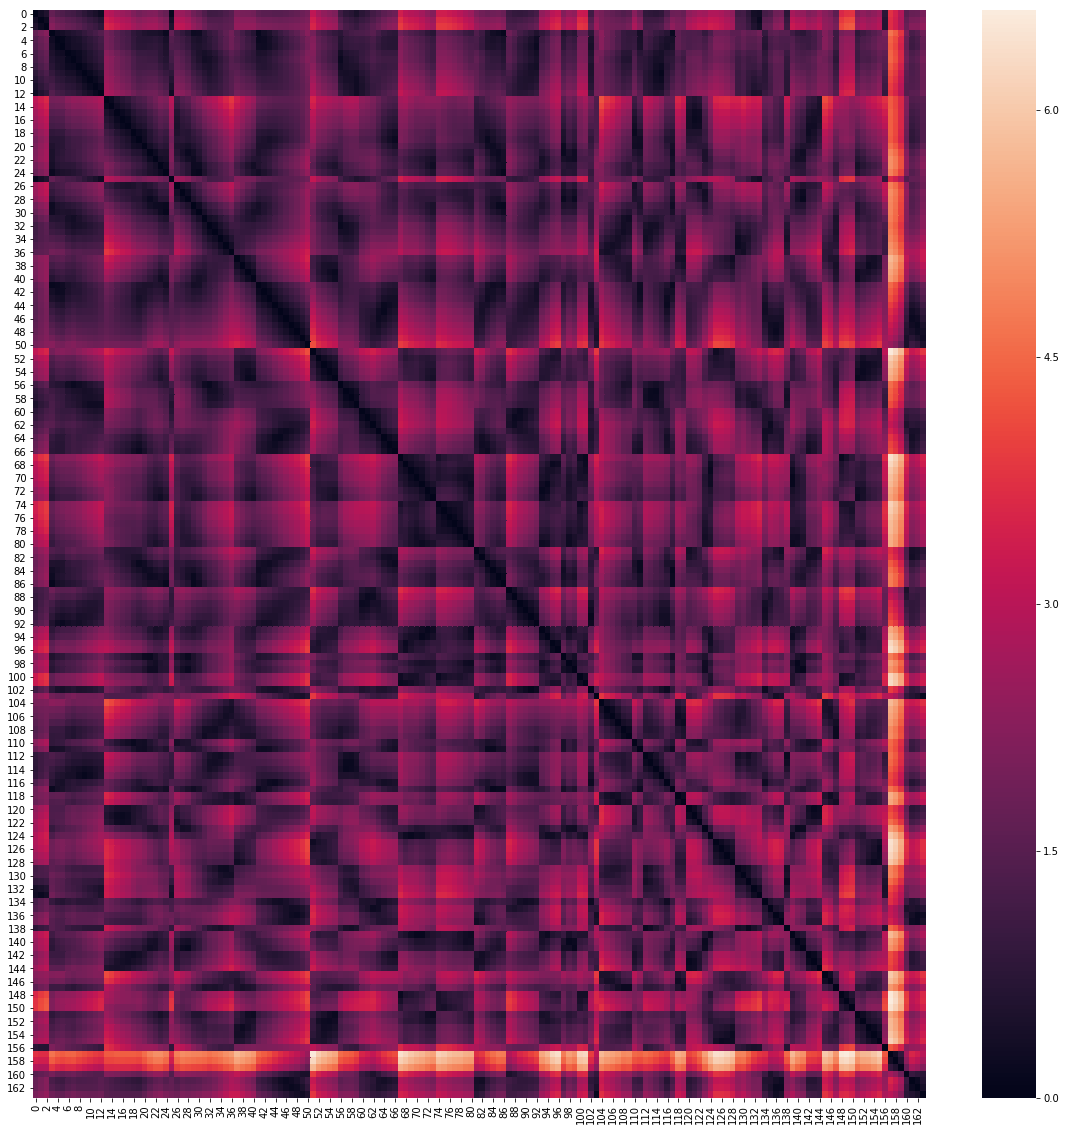

In [171]:
sns.heatmap(dist_matrix_geo)

In [187]:
# Now calculate the 2D embedding
from sklearn.manifold import MDS


mds = MDS(n_components=2, metric=False, dissimilarity='precomputed')

# force symmetry
graph_completed_clean_mds = np.maximum(graph_completed_clean, graph_completed_clean.transpose() )

graph_to_fit_mds = 1*graph_completed_clean_mds

new_coordinates = mds.fit_transform(graph_to_fit_mds)
new_coordinates.shape

np.sqrt(mds.stress_/new_coordinates.shape[0])

1.9143951988946295

In [144]:
# MDS based on geo location
stops_.head()


,stop_id,stop_name,stop_lat,stop_lon
0,8500254,"Basel, Wiesenplatz",47.576697,7.591384
1,8589334,"Basel, Kleinhüningen",47.581054,7.592453
2,8589374,"Basel, Kleinhüningeranlage",47.583708,7.593818
3,8500897,"Basel, Barfüsserplatz",47.554591,7.589057
4,8588775,"Basel, Marktplatz",47.558107,7.587602


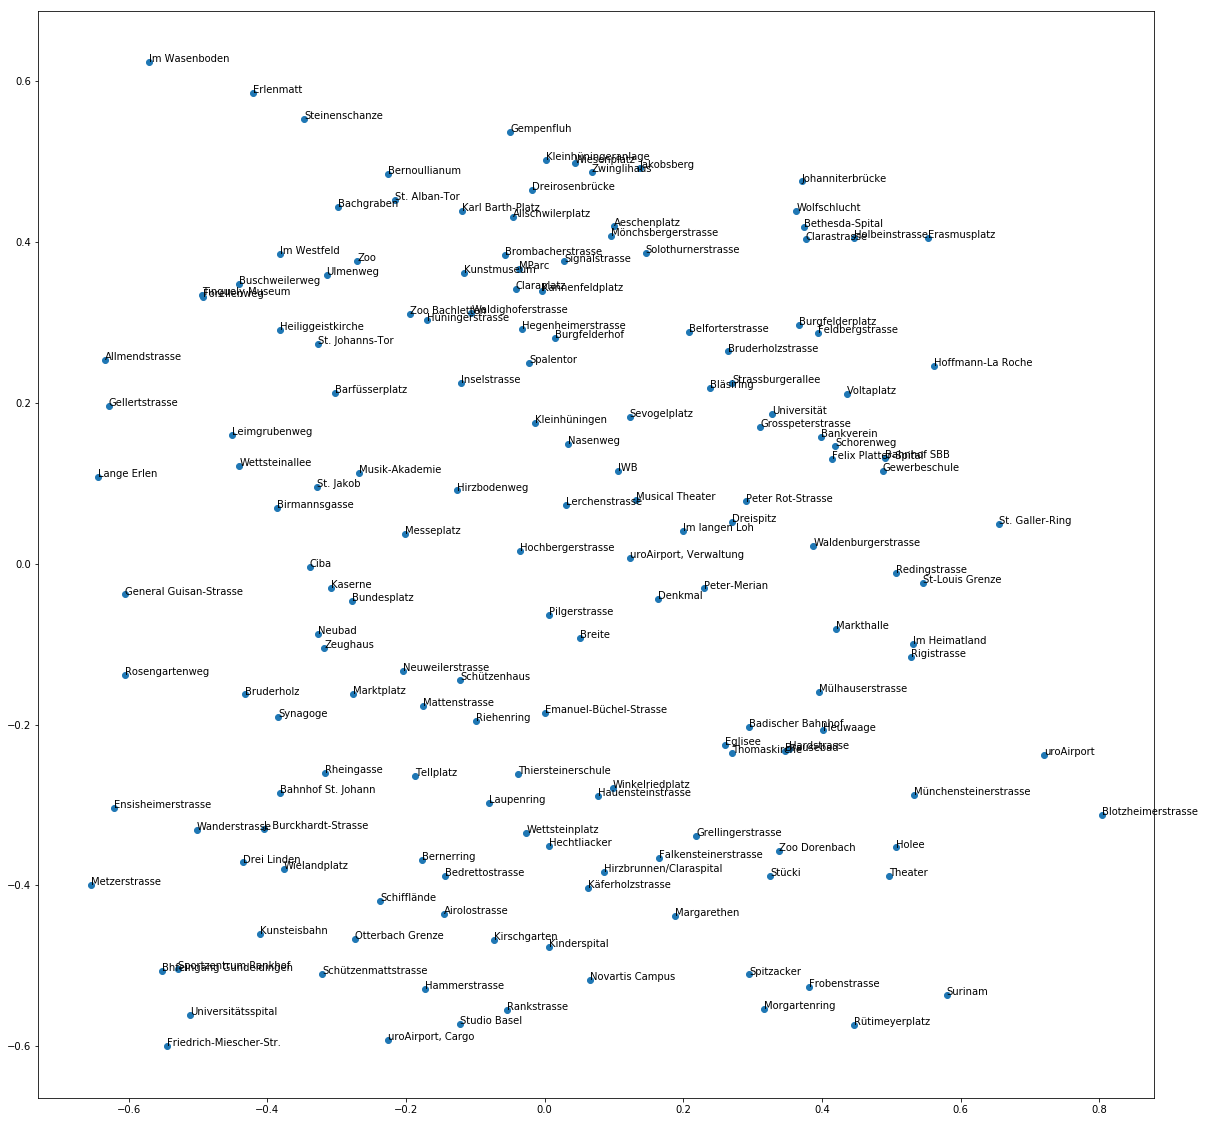

In [185]:
fig, ax = plt.subplots(1,1)

ax.scatter(new_coordinates[:,0], new_coordinates[:,1])

for i, txt in enumerate(stops_.stop_name):
    ax.annotate(txt[7:], (new_coordinates[i,0], new_coordinates[i,1]))

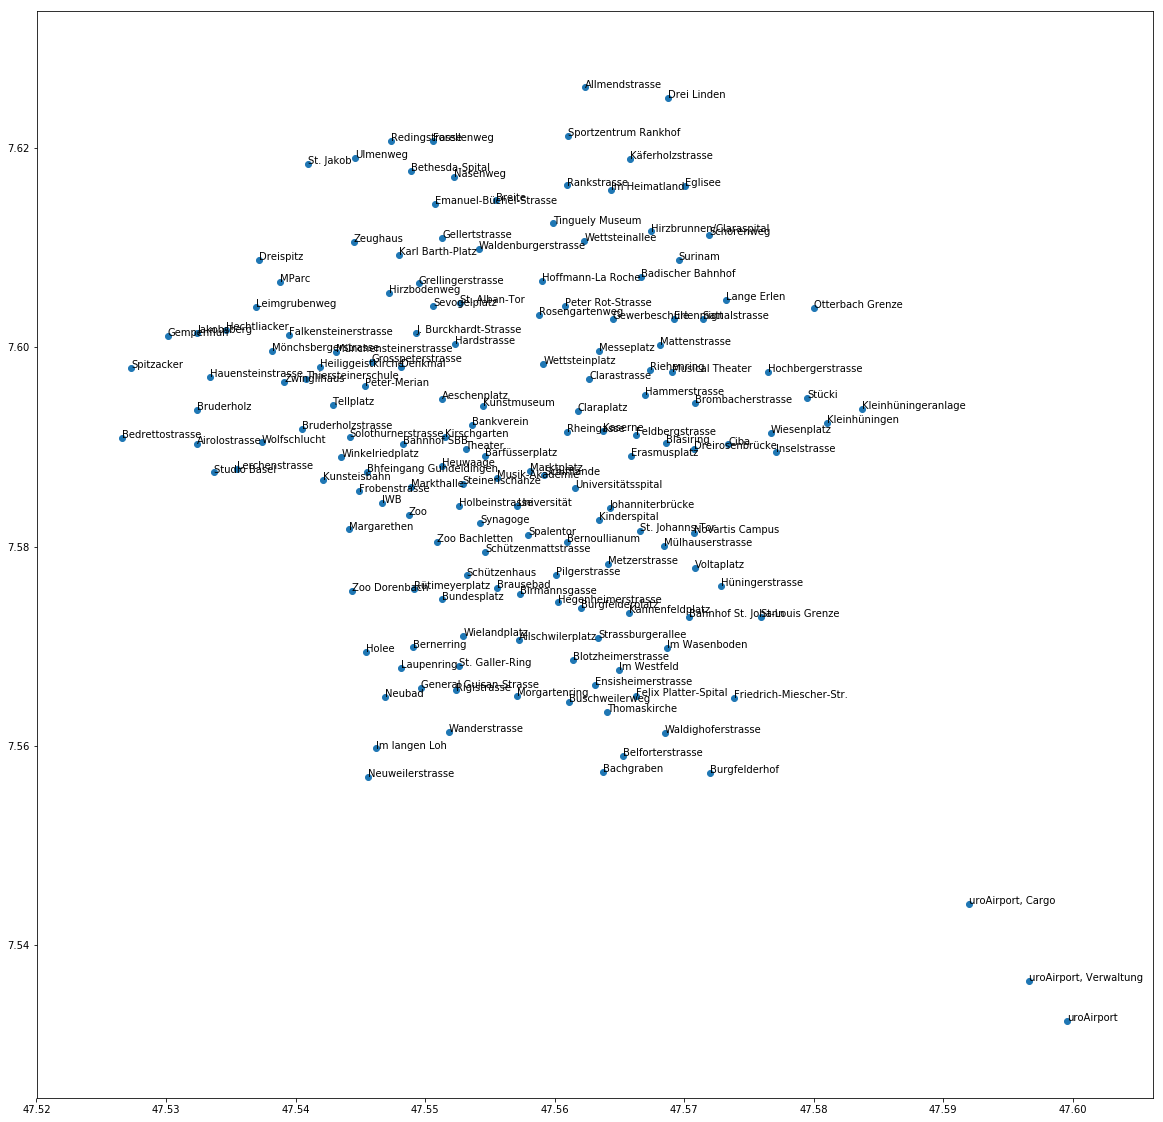

In [162]:
fig, ax = plt.subplots(1,1)

ax.scatter(stops_.stop_lat.values, stops_.stop_lon.values)

for i, txt in enumerate(stops_.stop_name):
    ax.annotate(txt[7:], (stops_.stop_lat[i], stops_.stop_lon[i]))

In [276]:
stops_named.shape

(164, 1)

In [260]:
def extractor(x):
    if len(x) > 0:
        return x[0]
    else:
        return ""
    
    
test = pd.merge(pd.DataFrame({"stop_name": stops_named.apply(extractor)}), stops, left_on="stop_name", right_on="stop_name")
test_ = test.apply(collapse_stop_id, axis=1, result_type='broadcast')

from sklearn.metrics.pairwise import euclidean_distances

# for each stop in original graph
    # compute distance in euclidean space
    
graph_test = np.zeros_like(graph_completed_clean)

nstops = graph_test.shape[0]

for ix in range(nstops):
    for jx in range(ix, nstops):
        
        cur_stop_ix = get_stop_name(ix)
        cur_stop_jx = get_stop_name(jx)
        
        cur_stop_ix_data = stops.loc[stops['stop_name'].isin(cur_stop_ix), ['stop_lat', 'stop_lon']].values
        cur_stop_jx_data = stops.loc[stops['stop_name'].isin(cur_stop_jx), ['stop_lat', 'stop_lon']].values
    
        graph_test[ix, jx] = euclidean_distances(cur_stop_ix_data, cur_stop_jx_data)



ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by check_pairwise_arrays.

In [266]:
get_stop_name(2)

[]

In [277]:
stops_named.shape

(164, 1)

In [278]:
new_coordinates.shape

(164, 2)

In [270]:
np.sum(keep)

164

In [271]:
keep

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,

In [138]:
def pklio(file, var=None):
    '''Loads or saves variable to/from file, depending on whether a variable is passed.
    Imports pickle if necessary.'''
    
    if 'pkl' not in locals():
        import pickle as pkl
    
    # Load variable from file
    if var is None:
        with open(file, 'rb') as f:
            return pkl.load(f)
        
    # Save variable to file
    else:
        with open(file, 'ab') as f:
            pkl.dump(var, f)  

In [139]:
a = 12
pklio('a.pkl', a)

In [140]:
b = pklio('a.pkl')

In [141]:
b

12

In [133]:
ls

4_tu_ch_oev_sammlung_ch__2021_20211204_203256/
4_tu_ch_oev_sammlung_ch__2021_20211204_203256 (1)/
4_tu_ch_oev_sammlung_ch__2021_20211204_203256 (1).zip
4_tu_ch_oev_sammlung_ch__2021_20211204_203256.zip
Basel_trips.xlsx
a.pkl
basel_distmatrix.png
bidimensional_regression_test.ipynb
graphischer-fahrplan.csv
gtfs_fp2021_2021-12-01_09-10/
gtfs_fp2021_2021-12-01_09-10.zip
sbb-gtfs.ipynb
sbb.ipynb
shapefiles/
zurich_distmatrix.png
~$Basel_trips.xlsx
